# Counting DL and DLT histories: paper figures
### Cedric Chauve, 04/02/2019

### Abstract.
This notebook contains the code used to analyse our experimental results and generate figures that might be included in a paper. We also list pending questions.

In [1]:
# Hiding te code from the notebook

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
import io
import math

## Introduction

In this notebook, we consider 4 *models*: unranked DL (*U-DL*), ranked Dl (*R-DL*), unranked DLT (*U-DLT*) and ranked DLT (*R-DLT*). For each model, we generated $100$ species tree of size $k$ as follows: the caterpillar, if $k$ is a power of $2$, the compkete binary tree, and the remaining species trees are generated at rendom under the uniform distribution. Note that in this setting, for small values of $k$, some species trees are generated several times. Moreover, in the two ranked model, for each species tree, we generated $10$ random rankings, again chosen under the uniform distribution. Finally for each input (to be understood as a species tree $S$ of size $k$, together with a ranking if we are in a ranked model), we counted the number of histories (in the chosen model) of size $n$. Our range parameter is $k \in [3,22]$ (experiments are still running for the ranked model for $k\in [23, 32]$) and $n\in [1,50]$.



In [3]:
# Parameters

# Number of species trees per size
NB_S_TREES    = 100
S_TREES_INDEX = [i for i in range(0,NB_S_TREES)]
# Evolutionary models
EVOL_MODELS = [('U','DL'),('U','DLT'),('R','DL'),('R','DLT')]
# Species tree sizes
K_MIN = 3
K_MAX = 26 #target: 32 but computations did not finish past k=26
K_LIST = [k for k in range(K_MIN,K_MAX+1)]
# Histories sizes
N_MIN = 1
N_MAX = 50
N_LIST = [n for n in range(N_MIN,N_MAX+1)]
# Paths to results
PREFIX_UNRANKED    = '../../exp/09-01-2019-exp1-redone/results/exp1a'
PREFIX_RANKED      = '../../exp/01-02-2019-exp1-ranking/results/exp1'
PREFIX_ASYMPTOTICS = '../../exp/29-01-2019-exp1-redone-2/systems/exp1a'
# Rankings
R_MAX  = 10
R_LIST = [r for r in range(1,R_MAX+1)]

In [4]:
# Subset of the parameter space for more readable figures
K_LIST_REDUCED = [5,10,15,20,25]
K_LIST_POW2    = [4,8,16]
N_LIST_REDUCED = [10,20,30,40,50]

In [5]:
# Reading the exact counting results
# Format: RESULTS_ALL[evol_model][s][n][tree_index] is 
# the list of the number of histories of size n for tree tree_index of size s in model evol_model 
# the list is of size 1 if the tree is unranked

RESULTS_aux = {m:{k:{n:{t:[] for t in S_TREES_INDEX} for n in N_LIST}  for k in K_LIST} for m in EVOL_MODELS}
    
def read_counting_file(fileName,k):
    with gzip.open(fileName, 'r') as f:
        reader = csv.reader(io.TextIOWrapper(f, newline=""),delimiter='\t')        
        for row in reader:
            if row[0][0]!='#':
                model     = (row[2],row[3])
                treeIndex = int(row[1])
                row5      = row[5].split()
                for n in N_LIST:
                    RESULTS_aux[model][k][n][treeIndex].append(int(row5[n-1]))
    
for k in K_LIST:
    read_counting_file(PREFIX_UNRANKED+'_'+str(k)+'.gz',k)
    read_counting_file(PREFIX_RANKED+'_'+str(k)+'.gz',k)
                            
RESULTS_COUNTING = pd.DataFrame.from_dict({(m,k,n): RESULTS_aux[m][k][n]
                                            for m in RESULTS_aux.keys() 
                                            for k in RESULTS_aux[m].keys()
                                            for n in RESULTS_aux[m][k].keys()},
                                            orient='index')

In [6]:
# Reading the asymptotics results for the model (U,DL)

RESULTS_aux = {k:{t:0 for t in S_TREES_INDEX}  for k in K_LIST}
for k in K_LIST:
    dataAsympt = open(PREFIX_ASYMPTOTICS+'_'+str(k)+'_asy').readlines()
    for row in dataAsympt:
        if row[0] != '#':
            row1        = row.rstrip().split('\t')
            treeIndex   = int(row1[1])
            asymptotics =  float(row1[2])
            RESULTS_aux[k][treeIndex] = asymptotics
RESULTS_ASYMPTOTICS_U_DL = pd.DataFrame.from_dict({(k): RESULTS_aux[k]
                                                for k in RESULTS_aux.keys()},
                                                orient='index')

In [7]:
# Reading the number of subtrees and the height per species tree

RESULTS_aux = {k:{t:0 for t in S_TREES_INDEX}  for k in K_LIST}
for k in K_LIST:
    subtrees = open(PREFIX_UNRANKED+'_'+str(k)+'_add1').readlines()
    for row in subtrees:
        if row[0] != '#':
            row1        = row.rstrip().split('\t')
            treeIndex   = int(row1[1])
            nbSubtrees    = row1[3].count('(')
            RESULTS_aux[k][treeIndex] = nbSubtrees
RESULTS_SUBTREES = pd.DataFrame.from_dict({(k): RESULTS_aux[k]
                                                for k in RESULTS_aux.keys()},
                                                orient='index')

RESULTS_aux = {k:{t:0 for t in S_TREES_INDEX}  for k in K_LIST}
for k in K_LIST:
    subtrees = open(PREFIX_UNRANKED+'_'+str(k)+'_add2').readlines()
    for row in subtrees:
        if row[0] != '#':
            row1        = row.rstrip().split('\t')
            treeIndex   = int(row1[1])
            height      = int(row1[3])
            RESULTS_aux[k][treeIndex] = height
RESULTS_HEIGHT = pd.DataFrame.from_dict({(k): RESULTS_aux[k]
                                                for k in RESULTS_aux.keys()},
                                                orient='index')

## Asymptotics in the unranked DL model

We first look at the simplest model, the U-DL model, where we can obtain theortical asymptotics estimates. Here we assume that for a given species tree $S$ and a given history size $n$, we have
$$a_n \simeq C_S \frac{\lambda_S^n}{n^{3/2}}\left(1+O\left(\frac{1}{n}\right)\right).$$
We call $\lambda_S$ the *growth constant* and $C_u$ the *constant*.

**Method.** Currently, Michael generates, from the input tree, the set of equations whose solution gives the growth constant. This set of equations is then solved using *SciPy* to obtain $\lambda_U$. To approximate $C_S$, we take the exact counting term at $a_{50}$ and divides it by $n^{3/2}/\lambda_S{n}$.

**Question Q1.** Can-we expect the same form of asymptotics for the three other models? Likely for the R-DL model, as the only difference is that the given species tree can have uniary nodes. 

**Question Q2.** How should we provide the grammar/specification in the U-DLT and R-DLT models in order to be able to do automatic asymptotics?

<Figure size 432x288 with 0 Axes>

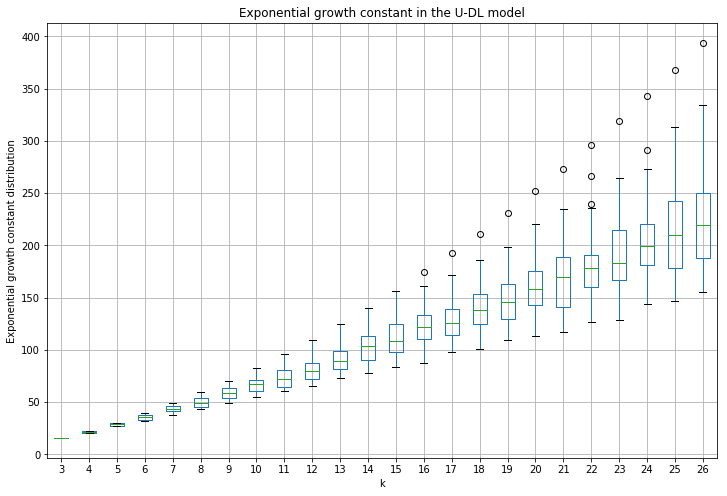

In [8]:
plt.figure()
ax_asympt1 = RESULTS_ASYMPTOTICS_U_DL.transpose().plot(kind='box', grid=True, return_type='axes', figsize=(12,8), title='Exponential growth constant in the U-DL model')
ax_asympt1.set_ylabel('Exponential growth constant distribution')
ax_asympt1.set_xlabel('k')
plt.savefig('growth_factor_U_DL.png')
plt.show()

We can observe that the minimum and mean value seem to grow linearly, while the max value seems to grow non-linearly. Note however that this is over a sample of species tree so the results might not be extremely robust for larger values of $k$. We can also notice that the growth constant is very large, greater than $200$ for some species trees of size only $22$.

We now look at the constants $C_S$.

In [9]:
# Computing the constants
CONSTANTS_U_DL_aux = {k:{t:0 for t in S_TREES_INDEX}  for k in K_LIST}
for k in K_LIST:
    for t in S_TREES_INDEX:
        n = N_MAX
        exact    = RESULTS_COUNTING.at[(('U','DL'),k,n),t][0]
        growth   = RESULTS_ASYMPTOTICS_U_DL.at[k,t]
        asympt   = math.pow(growth,n) / math.pow(n,1.5)
        constant = exact / asympt
        CONSTANTS_U_DL_aux[k][t] = constant
CONSTANTS_U_DL = pd.DataFrame.from_dict({k: CONSTANTS_U_DL_aux[k]
                                        for k in CONSTANTS_U_DL_aux.keys()},
                                        orient='index')

<Figure size 432x288 with 0 Axes>

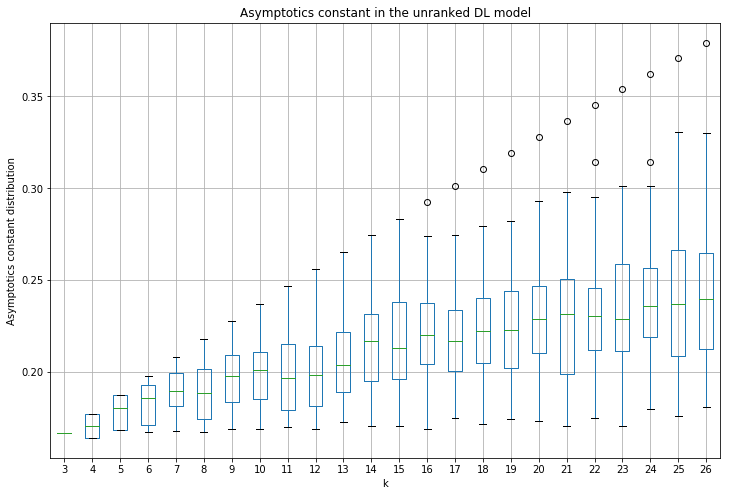

In [10]:
plt.figure()
ax_asympt2 = CONSTANTS_U_DL.transpose().plot(kind='box', grid=True, return_type='axes', figsize=(12,8), title='Asymptotics constant in the unranked DL model')
ax_asympt2.set_ylabel('Asymptotics constant distribution')
ax_asympt2.set_xlabel('k')
plt.savefig('constants_U_DL.png')
plt.show()

We can observe that the max constant grows linearly, but otherwise we have a much less nice growng pattern than for the growth factor.

We are now looking at the species tree that leads to extreme growth factor.

In [11]:
def check_min_max_growth_factor(df):
    df_min = df.idxmin(axis=1)
    df_max = df.idxmax(axis=1)
    for k in K_LIST:
        if df_max[k] == 0:
            print('k = '+str(k)+': species tree with max. growth constant is the caterpillar')
        if k in K_LIST_POW2 and df_min[k] == 1:
            print('k = '+str(k)+': species tree with min. growth constant is the complete binary tree')
check_min_max_growth_factor(RESULTS_ASYMPTOTICS_U_DL)

k = 3: species tree with max. growth constant is the caterpillar
k = 4: species tree with max. growth constant is the caterpillar
k = 4: species tree with min. growth constant is the complete binary tree
k = 5: species tree with max. growth constant is the caterpillar
k = 6: species tree with max. growth constant is the caterpillar
k = 7: species tree with max. growth constant is the caterpillar
k = 8: species tree with max. growth constant is the caterpillar
k = 8: species tree with min. growth constant is the complete binary tree
k = 9: species tree with max. growth constant is the caterpillar
k = 10: species tree with max. growth constant is the caterpillar
k = 11: species tree with max. growth constant is the caterpillar
k = 12: species tree with max. growth constant is the caterpillar
k = 13: species tree with max. growth constant is the caterpillar
k = 14: species tree with max. growth constant is the caterpillar
k = 15: species tree with max. growth constant is the caterpillar
k

We can check above that the caterpillar always leads to the maximum growth constant and that if $k$ is a power of $2$, the complete binary tree leads to the minimum growth constant.

We look below at the growth of the growth constant for the caterpillar, to check it is not linear.

<Figure size 432x288 with 0 Axes>

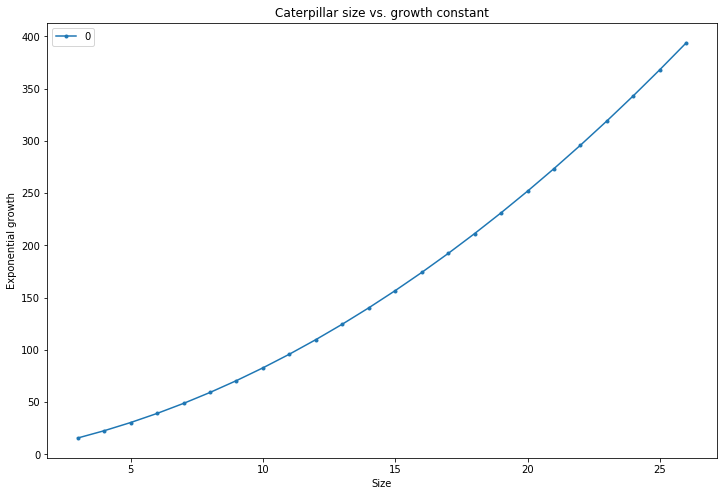

In [12]:
plt.figure()
ax_asympt3 = pd.DataFrame(RESULTS_ASYMPTOTICS_U_DL[0]).plot(kind='line', style='.-', figsize=(12,8), title='Caterpillar size vs. growth constant')
ax_asympt3.set_xlabel('Size')
ax_asympt3.set_ylabel('Exponential growth')
plt.savefig('Caterpillar_size_vs_exp_growth_U_DL.png')
plt.show()

In [13]:
def check_max_constant(df):
    df_max = df.idxmax(axis=1)
    for k in K_LIST:
        if df_max[k] == 0:
            print('k = '+str(k)+': the species tree with the maximum constant is the caterpillar')
check_max_constant(RESULTS_ASYMPTOTICS_U_DL)

k = 3: the species tree with the maximum constant is the caterpillar
k = 4: the species tree with the maximum constant is the caterpillar
k = 5: the species tree with the maximum constant is the caterpillar
k = 6: the species tree with the maximum constant is the caterpillar
k = 7: the species tree with the maximum constant is the caterpillar
k = 8: the species tree with the maximum constant is the caterpillar
k = 9: the species tree with the maximum constant is the caterpillar
k = 10: the species tree with the maximum constant is the caterpillar
k = 11: the species tree with the maximum constant is the caterpillar
k = 12: the species tree with the maximum constant is the caterpillar
k = 13: the species tree with the maximum constant is the caterpillar
k = 14: the species tree with the maximum constant is the caterpillar
k = 15: the species tree with the maximum constant is the caterpillar
k = 16: the species tree with the maximum constant is the caterpillar
k = 17: the species tree wi

So for the constants $C_S$, the maximum is always attained with the caterpillar.

## Link between the number of subtrees and the growth constant in the U-DL model

A hypothesis is that the number of different subtrees in the given species tree $S$ plays an important role in the growth constant. To assess this, we generate a scatter plot, over all sizes $k$ where each point is a species tree $S$ whose coordinates are the nmber of subtrees it contains ($x$-axis) and the growth constant ($y$-axis).

<Figure size 432x288 with 0 Axes>

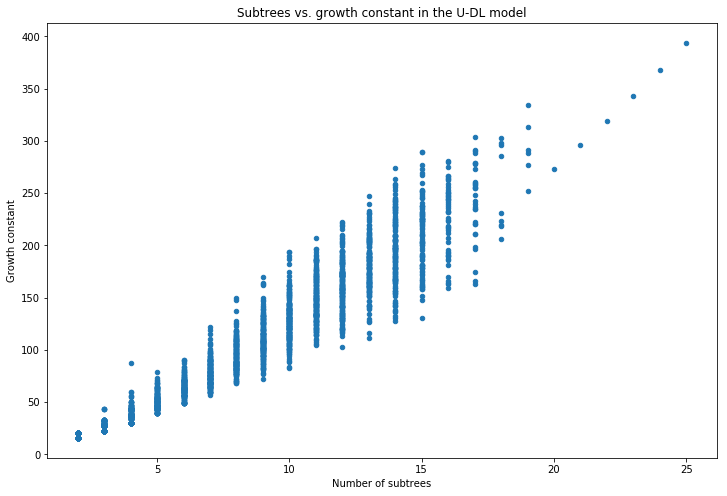

In [14]:
# Creating a dataframe matching exp. growth and number of subtrees
RESULTS_SUBTREES_ASYMPTOTICS =  pd.concat([pd.DataFrame(RESULTS_SUBTREES.stack(),columns=['subtrees']),
                                           pd.DataFrame(RESULTS_ASYMPTOTICS_U_DL.stack(),columns=['exp. growth'])],
                                           axis=1)

plt.figure()
ax_subtrees1 = RESULTS_SUBTREES_ASYMPTOTICS.plot(kind='scatter', x='subtrees', y='exp. growth', figsize=(12,8), title='Subtrees vs. growth constant in the U-DL model')
ax_subtrees1.set_xlabel('Number of subtrees')
ax_subtrees1.set_ylabel('Growth constant')
plt.savefig('Subtrees_vs_exp_growth_U_DL.png')
plt.show()

We can observe a pretty large spread for each value of the number of subtrees, that shows that the number of subtrees. To see the effect of aggregating all values of $k$ together, we plot now the same kind of scatter plot but for $4$ specific values of $k$.

<Figure size 432x288 with 0 Axes>

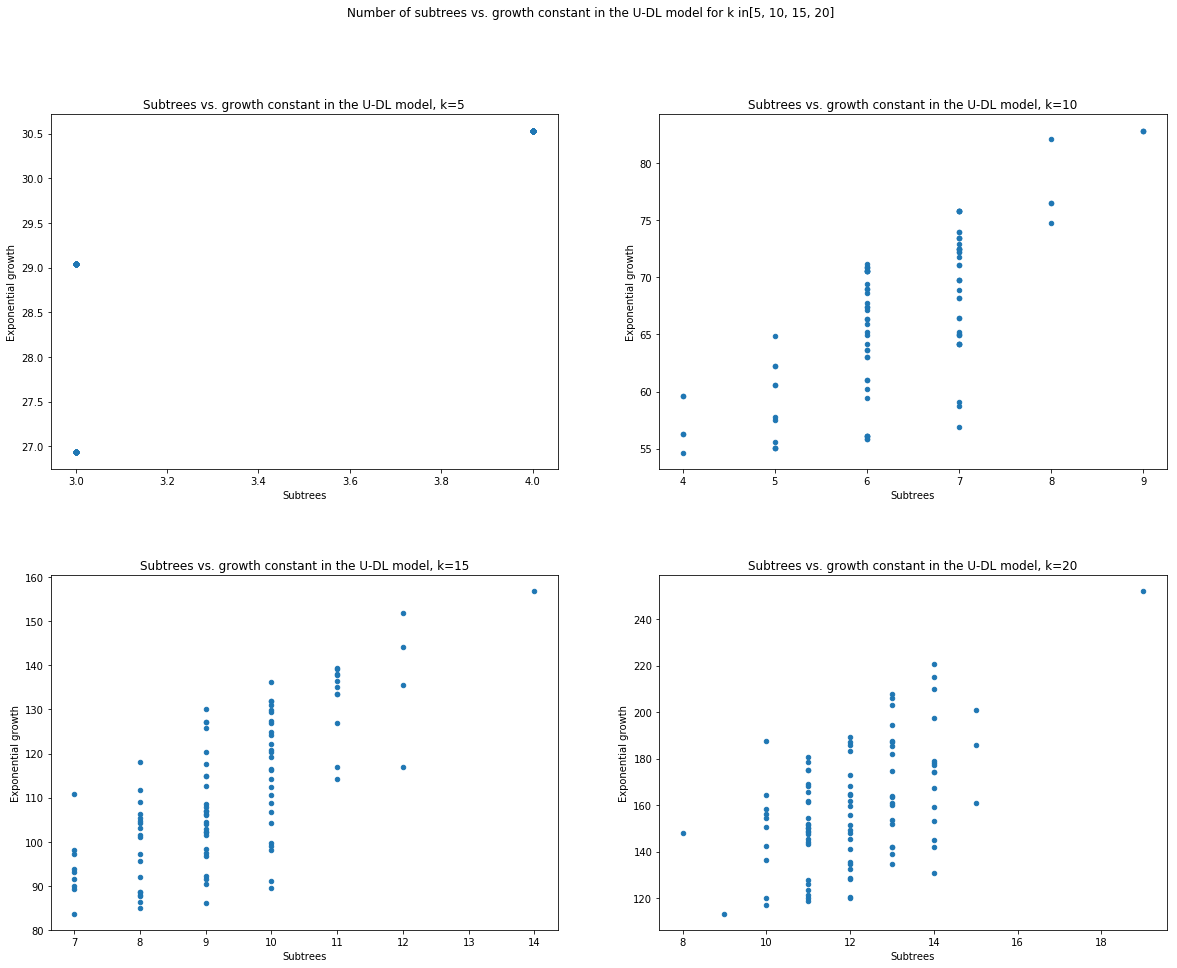

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [25]:
# Plotting the scatter plot for a given value of k

def plot_subtrees_vs_exp_growth_per_k_single(k):
    offset = 3
    K = k-offset
    plt.figure()
    ax = pd.DataFrame(RESULTS_SUBTREES_ASYMPTOTICS.iloc[K*100:((K+1)*100)-1]).plot(kind='scatter', x='subtrees', y='exp. growth', figsize=(12,8), title='Subtrees vs. growth constant in the U-DL model, k='+str(k))
    ax.set_xlabel('Subtrees')
    ax.set_ylabel('Exponential growth')
    plt.savefig('Subtrees_vs_exp_growth_U_DL_'+str(k)+'.png')
    plt.show()

    
def plot_subtrees_vs_exp_growth_per_k(k,axe):
    offset = 3
    K = k-offset
    plt.figure()
    ax = pd.DataFrame(RESULTS_SUBTREES_ASYMPTOTICS.iloc[K*100:((K+1)*100)-1]).plot(ax=axe, kind='scatter', x='subtrees', y='exp. growth', title='Subtrees vs. growth constant in the U-DL model, k='+str(k))
    ax.set_xlabel('Subtrees')
    ax.set_ylabel('Exponential growth')
    plt.savefig('Subtrees_vs_exp_growth_U_DL_'+str(k)+'.png')

def show_subtrees_vs_exp_growth_per_k(k):
    offset = 3
    K = k-offset
    return(RESULTS_SUBTREES_ASYMPTOTICS.iloc[K*100:((K+1)*100)-1].drop_duplicates(keep='first',inplace=False).sort_values(by=['exp. growth','subtrees']))

plt.figure()
fig_subtrees2, ax_subtrees2 = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
plt.subplots_adjust(hspace = 0.3)
fig_subtrees2.suptitle('Number of subtrees vs. growth constant in the U-DL model for k in'+str(K_LIST_REDUCED[0:4]))
plot_subtrees_vs_exp_growth_per_k(K_LIST_REDUCED[0],ax_subtrees2[0,0])
plot_subtrees_vs_exp_growth_per_k(K_LIST_REDUCED[1],ax_subtrees2[0,1])
plot_subtrees_vs_exp_growth_per_k(K_LIST_REDUCED[2],ax_subtrees2[1,0])
plot_subtrees_vs_exp_growth_per_k(K_LIST_REDUCED[3],ax_subtrees2[1,1])
plt.show()

The spread for a given number of subtrees is still very clear.

We can also observe that the smallest gowth constant is actually not always a species tree with the minimum number of subtrees. 

For example, for $k=20$ (figure below) thise tree with a minimum number of subtrees has some kind of caterpillar flavor. The two images below are respectively the only sampled species tree of size $20$ with $8$ subtrees (lowest sampled value) and the only sampled species tree of size $20$ with $9$ subtrees (second lowest sampled value and lowest growth constant), which has a clear complete binary tree flavor.

<img src="S_20_43.png" style="width: 500px;">

<img src="S_20_70.png" style="width: 500px;">

<Figure size 432x288 with 0 Axes>

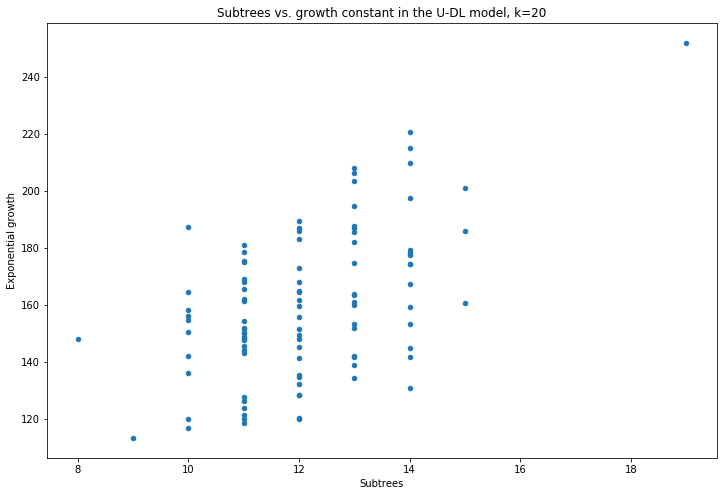

In [16]:
plot_subtrees_vs_exp_growth_per_k_single(20)

Last, we look at trees having only subtrees that are cherries of complete binary subtrees, to see if the topology of subtrees gives a lot of structure. By hand examination of our results, for the values of $k=4,6,8,10$, we di find the following trees.

Data: exponential gowth factor for trees whose subtrees are only cherries or complete subtrees (size, index, exp.growth)
- 4	1	[(1,0,0),(2,1,1)]  20.75303368753334
- 6	2	[(1,0,0),(2,1,1),(3,1,2)]   32.97020812702324
- 8	1	[(1,0,0),(2,1,1),(3,2,2)]   43.02457518155854
- 10 31	[(1,0,0),(2,1,1),(3,2,2),(4,1,3)]   59.589797487280855

Plotting the growth constant for these 4 trees does not show a linear relation.

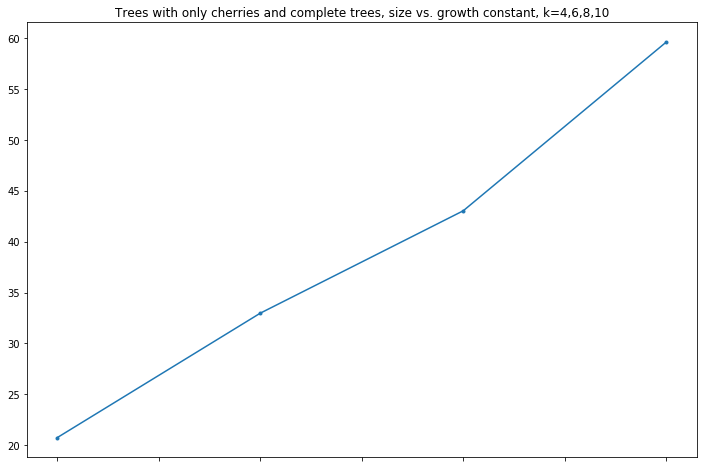

In [17]:
pd.DataFrame([RESULTS_SUBTREES_ASYMPTOTICS.iloc[101],
              RESULTS_SUBTREES_ASYMPTOTICS.iloc[302],
              RESULTS_SUBTREES_ASYMPTOTICS.iloc[501],
              RESULTS_SUBTREES_ASYMPTOTICS.iloc[731]])['exp. growth'].plot(style='.-', figsize=(12,8), title='Trees with only cherries and complete trees, size vs. growth constant, k=4,6,8,10')

We repeat the first figures of this section but using the height of the species trees instead of the number of subtrees.

<Figure size 432x288 with 0 Axes>

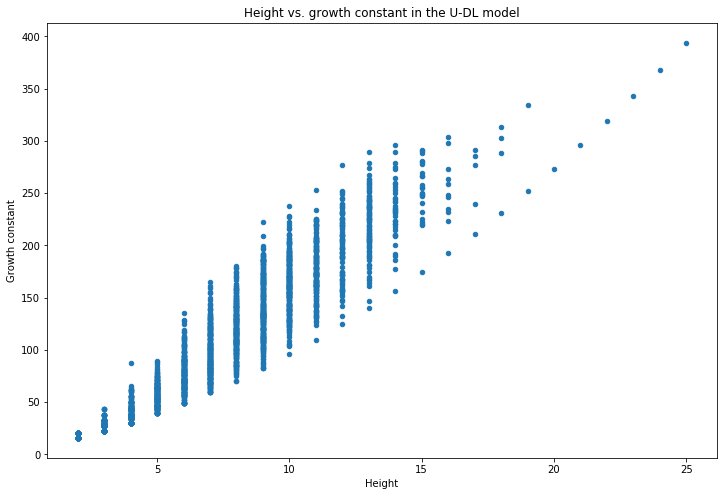

In [18]:
# Creating a dataframe matching exp. growth and number of subtrees
RESULTS_HEIGHT_ASYMPTOTICS =  pd.concat([pd.DataFrame(RESULTS_HEIGHT.stack(),columns=['height']),
                                         pd.DataFrame(RESULTS_ASYMPTOTICS_U_DL.stack(),columns=['exp. growth'])],
                                         axis=1)

plt.figure()
ax_height1 = RESULTS_HEIGHT_ASYMPTOTICS.plot(kind='scatter', x='height', y='exp. growth', figsize=(12,8), title='Height vs. growth constant in the U-DL model')
ax_height1.set_xlabel('Height')
ax_height1.set_ylabel('Growth constant')
plt.savefig('Height_vs_exp_growth_U_DL.png')
plt.show()

Note that, by the link between size and height, the bottom part of the plot corresponds to the caterpillar (see figure above), which we knew already because for a given height the caterpillar has the smallest number of histories.

<Figure size 432x288 with 0 Axes>

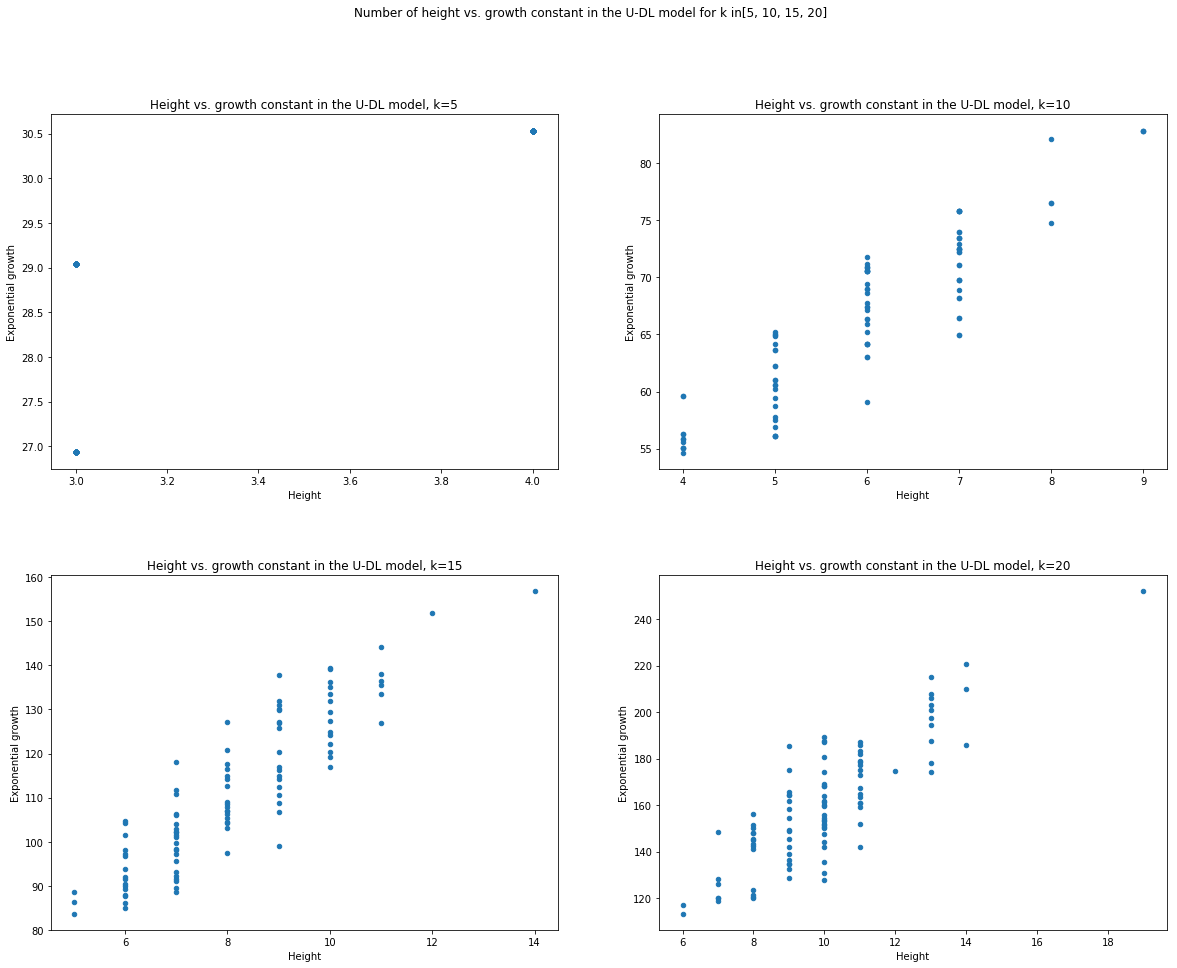

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [27]:
# Plotting the scatter plot for a given value of k

def plot_height_vs_exp_growth_per_k_single(k):
    offset = 3
    K = k-offset
    plt.figure()
    ax = pd.DataFrame(RESULTS_HEIGHT_ASYMPTOTICS.iloc[K*100:((K+1)*100)-1]).plot(kind='scatter', x='height', y='exp. growth', figsize=(12,8), title='Height vs. growth constant in the U-DL model, k='+str(k))
    ax.set_xlabel('Height')
    ax.set_ylabel('Exponential growth')
    plt.savefig('Height_vs_exp_growth_U_DL_'+str(k)+'.png')
    plt.show()

    
def plot_height_vs_exp_growth_per_k(k,axe):
    offset = 3
    K = k-offset
    plt.figure()
    ax = pd.DataFrame(RESULTS_HEIGHT_ASYMPTOTICS.iloc[K*100:((K+1)*100)-1]).plot(ax=axe, kind='scatter', x='height', y='exp. growth', title='Height vs. growth constant in the U-DL model, k='+str(k))
    ax.set_xlabel('Height')
    ax.set_ylabel('Exponential growth')
    plt.savefig('Height_vs_exp_growth_U_DL_'+str(k)+'.png')

def show_height_vs_exp_growth_per_k(k):
    offset = 3
    K = k-offset
    return(RESULTS_HEIGHT_ASYMPTOTICS.iloc[K*100:((K+1)*100)-1].drop_duplicates(keep='first',inplace=False).sort_values(by=['exp. growth','height']))

plt.figure()
fig_height2, ax_height2 = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
plt.subplots_adjust(hspace = 0.3)
fig_height2.suptitle('Number of height vs. growth constant in the U-DL model for k in'+str(K_LIST_REDUCED[0:4]))
plot_height_vs_exp_growth_per_k(K_LIST_REDUCED[0],ax_height2[0,0])
plot_height_vs_exp_growth_per_k(K_LIST_REDUCED[1],ax_height2[0,1])
plot_height_vs_exp_growth_per_k(K_LIST_REDUCED[2],ax_height2[1,0])
plot_height_vs_exp_growth_per_k(K_LIST_REDUCED[3],ax_height2[1,1])
plt.show()

### Conclusion.

The link between subtrees or height and the growth constant is not very clear and deserves further invertigation, although we observe a better correlation with height, especially in terms of minimal growth constants.

## Estmating the growth constant in an arbitrary model
We estimate the growth constant from the counting sequence using the formula
$$\lambda \simeq e^{\left(\frac{\ln\left(n^{3/2}a_n\right)}{n}\right)}.$$

In [20]:
#DL
a_2_50 = 5968253921235502760416442592758761277664264192
#DLT
c_2_50 = 8877599610037151300409838060668890197540602904576
n = 50
k = 2
print(math.exp(math.log(math.pow(n,1.5)*a_2_50)/n))
print(math.exp(math.log(math.pow(n,1.5)*c_2_50)/n))

9.25733640507417
10.713589727052838


In [21]:
def estimate_growth_constant(m,k,n):
    RESULTS_COUNTING_m_k_n = [ ]
    RESULTS_COUNTING_m_k_n_aux = RESULTS_COUNTING.loc[(m,k,n)]
    for i in RESULTS_COUNTING_m_k_n_aux.keys():
        RESULTS_COUNTING_m_k_n += RESULTS_COUNTING_m_k_n_aux[i]
    RESULTS_COUNTING_m_k_n_EXP_GROWTH = []
    for c in RESULTS_COUNTING_m_k_n:
        RESULTS_COUNTING_m_k_n_EXP_GROWTH.append(math.exp(math.log(n*math.sqrt(n)*c)/n))
    return(RESULTS_COUNTING_m_k_n_EXP_GROWTH)

RESULTS_ASYMPTOTICS_U_DLa = pd.DataFrame({k: estimate_growth_constant(('U','DL'),k,50) for k in K_LIST})
RESULTS_ASYMPTOTICS_R_DL  = pd.DataFrame({k: estimate_growth_constant(('R','DL'),k,50) for k in K_LIST})
RESULTS_ASYMPTOTICS_U_DLT = pd.DataFrame({k: estimate_growth_constant(('U','DLT'),k,50) for k in K_LIST})
RESULTS_ASYMPTOTICS_R_DLT = pd.DataFrame({k: estimate_growth_constant(('R','DLT'),k,50) for k in K_LIST})

<Figure size 432x288 with 0 Axes>

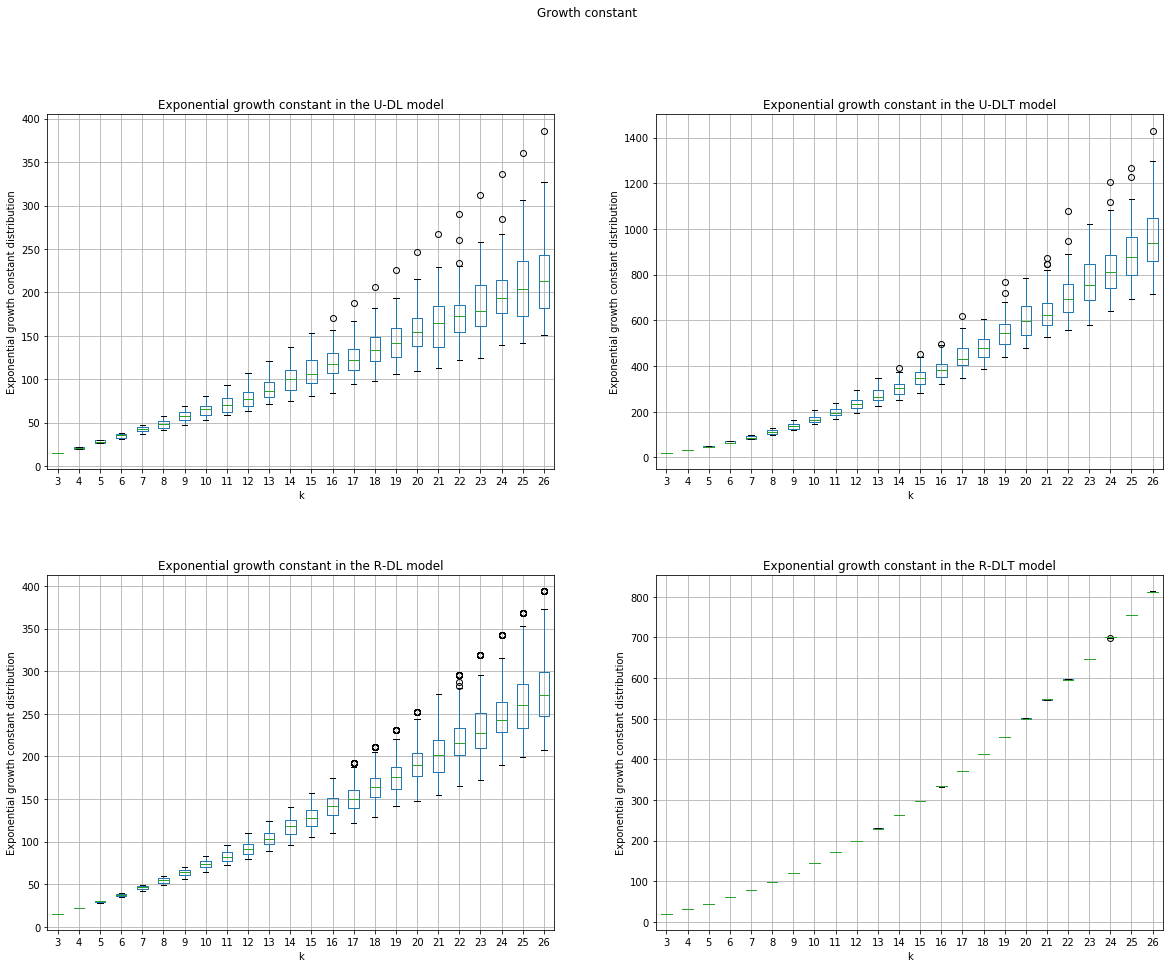

In [22]:
plt.figure()
fig_asympt4, ax_asympt4 = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
plt.subplots_adjust(hspace = 0.3)
fig_asympt4.suptitle('Growth constant')
RESULTS_ASYMPTOTICS_U_DLa.plot(ax = ax_asympt4[0,0], kind='box', grid=True, return_type='axes', title='Exponential growth constant in the U-DL model')
RESULTS_ASYMPTOTICS_U_DLT.plot(ax = ax_asympt4[0,1], kind='box', grid=True, return_type='axes',  title='Exponential growth constant in the U-DLT model')
RESULTS_ASYMPTOTICS_R_DL.plot(ax = ax_asympt4[1,0], kind='box', grid=True, return_type='axes',  title='Exponential growth constant in the R-DL model')
RESULTS_ASYMPTOTICS_R_DLT.plot(ax = ax_asympt4[1,1], kind='box', grid=True, return_type='axes', title='Exponential growth constant in the R-DLT model')
for ax in [ax_asympt4[0,0],ax_asympt4[0,1], ax_asympt4[1,0], ax_asympt4[1,1]]:
    ax.set_ylabel('Exponential growth constant distribution')
    ax.set_xlabel('k')
plt.show()

We can make a few observations. 

The first one is the very large increase of the estimated growth constant in the U-DLT model compared to the U-DL mode.

The second one is that, when comparing the U-DL and R-DL models, the impact of the ranking is that it reduce the spread of the estimate growth constants.

Last, and extremely striking, in the R-DLT model, the growth constant seems to almost not vary. It looks like tin this model, the species tree topology does not matter at all.

## Ratio DLT-histories / DL-histories

Last, we compute the ratio between the number of DLT-histories and the number of DL-histories in the ranked and unranked models.

<Figure size 432x288 with 0 Axes>

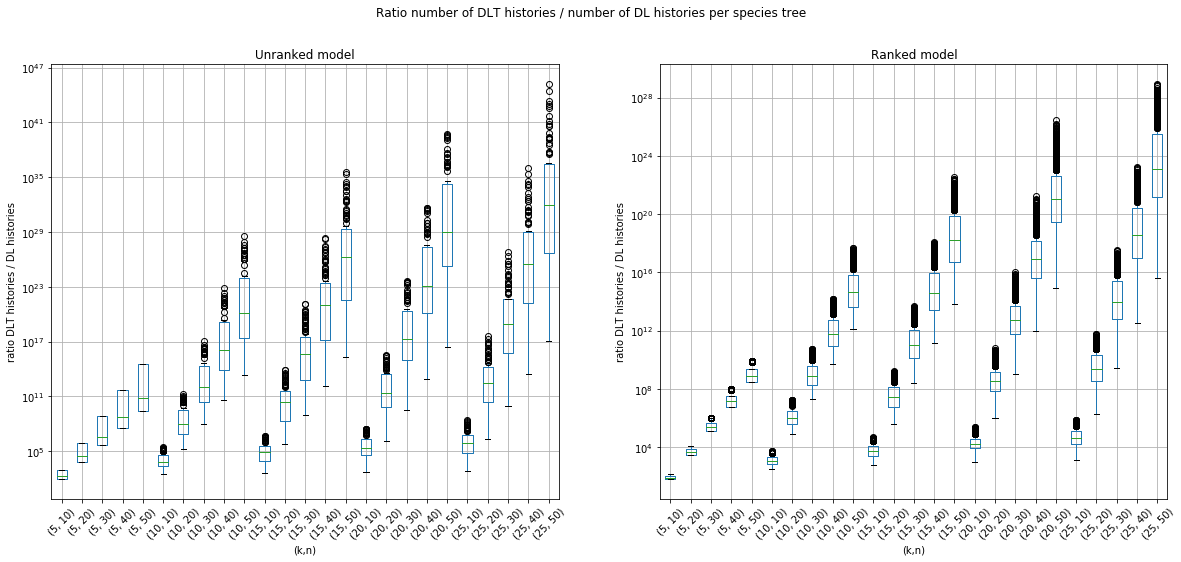

In [23]:
RESULTS_aux = {k:{n:{t:0 for t in S_TREES_INDEX} for n in N_LIST_REDUCED} for k in K_LIST_REDUCED}
for k in K_LIST_REDUCED:
    for n in N_LIST_REDUCED:
        for t in S_TREES_INDEX:
            dlth = RESULTS_COUNTING.at[(('U','DLT'),k,n),t][0]
            dlh  = RESULTS_COUNTING.at[(('U','DL'),k,n),t][0]
            RESULTS_aux[k][n][t] = dlth/dlh
RATIOS_U_DLT_DL = pd.DataFrame.from_dict({(k,n): RESULTS_aux[k][n]
                                        for k in RESULTS_aux.keys() 
                                        for n in RESULTS_aux[k].keys()},
                                        orient='index')

RESULTS_aux = {k:{n:{(t,r): 0 for r in R_LIST for t in S_TREES_INDEX} for n in N_LIST_REDUCED} for k in K_LIST_REDUCED}
for k in K_LIST_REDUCED:
    for n in N_LIST_REDUCED:
        for t in S_TREES_INDEX:
            for r in R_LIST:
                dlth = RESULTS_COUNTING.at[(('R','DLT'),k,n),t][r-1]
                dlh  = RESULTS_COUNTING.at[(('R','DL'),k,n),t][r-1]
                RESULTS_aux[k][n][(t,r)] = dlth/dlh
RATIOS_R_DLT_DL = pd.DataFrame.from_dict({(k,n): RESULTS_aux[k][n]
                                        for k in RESULTS_aux.keys() 
                                        for n in RESULTS_aux[k].keys()},
                                        orient='index')

plt.figure()
fig_ratio1, ax_ratio1 = plt.subplots(nrows=1, ncols=2, figsize=(20,8), sharex=True)
fig_ratio1.suptitle('Ratio number of DLT histories / number of DL histories per species tree')
RATIOS_U_DLT_DL.transpose().plot(ax=ax_ratio1[0], kind='box', grid=True, return_type='axes', title='Unranked model')
RATIOS_R_DLT_DL.transpose().plot(ax=ax_ratio1[1], kind='box', grid=True, return_type='axes', title='Ranked model')
for ax in ax_ratio1:
    ax.set_yscale('log')
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        ax.set_xlabel('(k,n)')
        ax.set_ylabel('ratio DLT histories / DL histories')
plt.savefig('ratio_DLT_DL_per_tree.png')
plt.show()

We can observe again the impact of adding transfers in a model, that results in a large increase of the number of histories.